In [1]:
%%html
<style>
.container{width: 100%}
</style>

In [2]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, date
from datetime import timedelta
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
def security_selection():
    asset_class = input("What asset class do you want? Equities or Index\n")
    if asset_class.lower() == "index":
        security = input("For what index do you want an option chain?\n")
        security = security.upper()
        url = 'https://www.nseindia.com/api/option-chain-indices?symbol='+ security
        print("\n",url)
    else:
        security = input("For what stock do you want an option chain?\n")
        security = security.upper()
        url = 'https://www.nseindia.com/api/option-chain-equities?symbol='+ security
        print("\n",url)
    return url

In [4]:
url = security_selection()

What asset class do you want? Equities or Index
equities
For what stock do you want an option chain?
reliance

 https://www.nseindia.com/api/option-chain-equities?symbol=RELIANCE


In [5]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'
    ,'accept-encoding': 'gzip, deflate, br'
    ,'accept-language': 'en-US,en;q=0.9'    
}

In [6]:
# Create a session and send request to get the data from the website
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [7]:
# Check the data structure of the raw data
rawdata

,records,filtered
expiryDates,"[31-Mar-2022, 28-Apr-2022, 26-May-2022]",NaN
data,"[{'strikePrice': 1800, 'expiryDate': '31-Mar-2...","[{'strikePrice': 1800, 'expiryDate': '31-Mar-2..."
timestamp,25-Feb-2022 15:30:00,NaN
underlyingValue,2283,NaN
strikePrices,"[1800, 1820, 1840, 1860, 1880, 1900, 1920, 194...",NaN
CE,NaN,"{'totOI': 38134, 'totVol': 86849}"
PE,NaN,"{'totOI': 20648, 'totVol': 33882}"


In [8]:
# Take the required cell into a dataframe to work on it
df= pd.DataFrame(response["records"]['data']).fillna(0)

In [9]:
# Check the structure of the underlying dataframe
df.iloc[0,2]

{'strikePrice': 1800,
 'expiryDate': '31-Mar-2022',
 'underlying': 'RELIANCE',
 'identifier': 'OPTSTKRELIANCE31-03-2022PE1800.00',
 'openInterest': 474,
 'changeinOpenInterest': 97,
 'pchangeinOpenInterest': 25.72944297082228,
 'totalTradedVolume': 775,
 'impliedVolatility': 45.68,
 'lastPrice': 4.3,
 'change': -5.500000000000001,
 'pChange': -56.122448979591844,
 'totalBuyQuantity': 65250,
 'totalSellQuantity': 49500,
 'bidQty': 1000,
 'bidprice': 4.2,
 'askQty': 250,
 'askPrice': 4.4,
 'underlyingValue': 2283}

In [10]:
# Convert the dataframe from a dict structure into a data frame structure
def option_dataframe(df):
    data = []
    for i in range(len(df)):
        call_oi = call_coi = put_oi = put_coi = call_vol = put_vol = int(0)
        call_IV = put_IV = call_ltp = put_ltp = float(0)
        strike = df.iloc[i,0]
        expiry = df.iloc[i,1]
        if(df.iloc[i,-1] == 0):
            calloi = call_coi = 0
        else:
            call_vol = df.iloc[i,-1]['totalTradedVolume']
            call_oi = df.iloc[i,-1]["openInterest"]
            call_coi = df.iloc[i,-1]["changeinOpenInterest"]
            call_ltp = df.iloc[i,-1]['lastPrice']
            call_IV = df.iloc[i,-1]['impliedVolatility']
        
        if(df.iloc[i,-2] == 0):
            putoi = put_coi = 0
        else:
            put_vol = df.iloc[i,-2]['totalTradedVolume']
            put_oi = df.iloc[i,-2]["openInterest"]
            put_coi = df.iloc[i,-2]["changeinOpenInterest"]
            put_ltp = df.iloc[i,-2]['lastPrice']
            put_IV = df.iloc[i,-2]['impliedVolatility']
            
        option_data = {"Expiry": expiry,
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call Vol" : call_vol ,"Call IV": call_IV ,"Call LTP" : call_ltp, "Strike" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put Vol": put_vol,"Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)

    return optionchain , df.iloc[0,-2]["underlyingValue"]

In [11]:
# Create an instance of the function by calling it
optionchain  , underlying_ltp = option_dataframe(df) 

In [12]:
# Check the Last traded price of the underlying security
underlying_ltp

2283

In [13]:
# Check the dataframe contating the options data
optionchain

,Expiry,Call OI,Call C_OI,Call Vol,Call IV,Call LTP,Strike,Put LTP,Put IV,Put Vol,Put C_OI,Put OI
0,31-Mar-2022,15,0,0,0.00,0.00,1800,4.3,45.68,775,97,474
1,28-Apr-2022,0,0,0,0.00,0.00,1800,0.0,0.00,0,0,0
2,26-May-2022,0,0,0,0.00,0.00,1800,0.0,0.00,0,0,0
3,31-Mar-2022,0,0,0,0.00,0.00,1820,0.0,0.00,0,0,0
4,31-Mar-2022,0,0,0,0.00,0.00,1840,0.0,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
109,31-Mar-2022,0,0,0,0.00,0.00,3060,0.0,0.00,0,0,0
110,31-Mar-2022,0,0,0,0.00,0.00,3080,0.0,0.00,0,0,0
111,31-Mar-2022,84,15,35,41.33,1.05,3100,0.0,0.00,0,0,0
112,31-Mar-2022,0,0,0,0.00,0.00,3120,0.0,0.00,0,0,0


In [14]:
# Create a list of strike prices and expires sorted in ascending order
strike_list = pd.Series(optionchain["Strike"].unique()).sort_values(ascending=True)
expiries_list = pd.to_datetime(optionchain["Expiry"].unique()).sort_values(ascending=True)

In [15]:
# Create a dictionary contaitng all the data sorted by the expiry
def by_expiry(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Expiry", "Strike"], ascending=True, inplace=True)
    option_dict = {}
    optionchain["Expiry"] = pd.to_datetime(optionchain["Expiry"])
    for i in  range(len(expiries_list)):
        option_dict[i] = optionchain.loc[optionchain["Expiry"] == expiries_list[i]]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"]==0) | (option_dict[i]["Put LTP"]==0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Expiry"], axis=1, inplace=True)
#         option_dict[i].drop(["Call LTP"])
    return option_dict

In [16]:
# Create another dictionary contaitng all the data sorted by the strikes
def by_strike(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Strike","Expiry"], inplace=True, ascending=True)
    option_dict = {}
    for i in  strike_list:
        option_dict[i] = optionchain.loc[optionchain["Strike"] == i]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"] == 0) | (option_dict[i]["Put LTP"] == 0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Strike"], axis=1, inplace=True)
    return option_dict

In [17]:
def strike_ATM():
    m = []
    a = 0
    for i in range(len(strike_list)):
        a = abs(underlying_ltp - strike_list[i])
        m.append(a)
        if a == min(m):
            min_strike = strike_list[i]
    return min_strike

In [18]:
ATM = strike_ATM()

In [19]:
underlying_ltp

2283

In [20]:
ATM

2280

In [21]:
expiry_df = by_expiry(optionchain, cutoff = 100)
strike_df = by_strike(optionchain, cutoff = 100)

In [22]:
# Check whether the expiry dictionary contains the data in the required format
expiry_df[0]

,Call OI,Call C_OI,Call Vol,Call IV,Call LTP,Strike,Put LTP,Put IV,Put Vol,Put C_OI,Put OI
0,154,89,122,26.54,213.50,2100,23.30,34.22,3805,763,2171
1,358,92,850,24.62,130.90,2200,43.50,31.46,5047,40,2797
2,160,16,1195,24.62,92.00,2260,64.65,30.82,2262,195,444
3,265,99,1942,24.95,81.70,2280,72.65,30.45,2385,207,489
4,3773,1527,17195,24.08,69.05,2300,81.90,30.27,5766,437,2866
5,728,221,3853,24.19,60.00,2320,92.70,30.39,597,-3,365
6,917,266,4464,24.35,52.00,2340,103.55,30.26,314,4,268
7,1092,214,3437,24.32,44.35,2360,113.60,29.57,143,0,415
8,949,162,3071,24.35,37.70,2380,129.30,30.71,87,-17,411
9,7505,2022,16789,24.44,32.00,2400,144.50,31.47,680,-20,2480


In [23]:
# Check whether the strike dictionary actually contains data in the required form
strike_df[ATM]

,Expiry,Call OI,Call C_OI,Call Vol,Call IV,Call LTP,Put LTP,Put IV,Put Vol,Put C_OI,Put OI
0,2022-03-31,265,99,1942,24.95,81.7,72.65,30.45,2385,207,489


In [24]:
# Define a function to plot the Skew of call and put options for a given expiry 
def plot_graph_expiry(options, expiry=0):
    plt.figure(figsize=(16,9))
    options[expiry] = options[expiry].drop(options[expiry][(options[expiry]["Call IV"] == 0) | (options[expiry]["Put IV"] == 0)].index)
    plt.plot(options[expiry]["Strike"],options[expiry]["Call IV"], color="b")
    plt.plot(options[expiry]["Strike"],options[expiry]["Put IV"], color='r')#, figure=(20,16)
    plt.grid('True')
    plt.title("Option Skew")
    plt.ylim(ymin=0)
    plt.xlabel("Strikes")
    plt.legend(["Call Skew","Put Skew"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [25]:
# Define a function to plot the term structure of a particular strike 
def plot_graph_strike(options, strike=17100):
    plt.figure(figsize=(16,9))
    options[strike]["Expiry"] = pd.to_datetime(options[strike]["Expiry"])
    options[strike] = options[strike].drop(options[strike][(options[strike]["Call IV"] == 0) | (options[strike]["Put IV"] == 0)].index)
    plt.plot(options[strike]["Expiry"], options[strike]["Call IV"])
    plt.plot(options[strike]["Expiry"], options[strike]["Put IV"], color = 'r')
    plt.grid('True')
    plt.title("Term Structure of " + str(strike) + " option.")
    plt.ylim(ymin=0)
    plt.legend(["Call Term Structure","Put Term Structure"])
    plt.ylabel("Implied Volatility")
    plt.show();

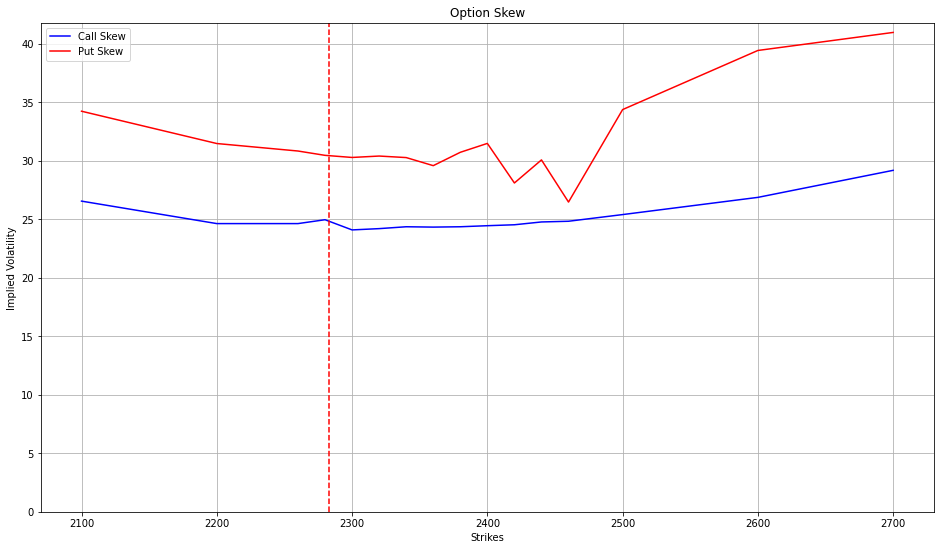

In [26]:
plot_graph_expiry(expiry_df,expiry=0)

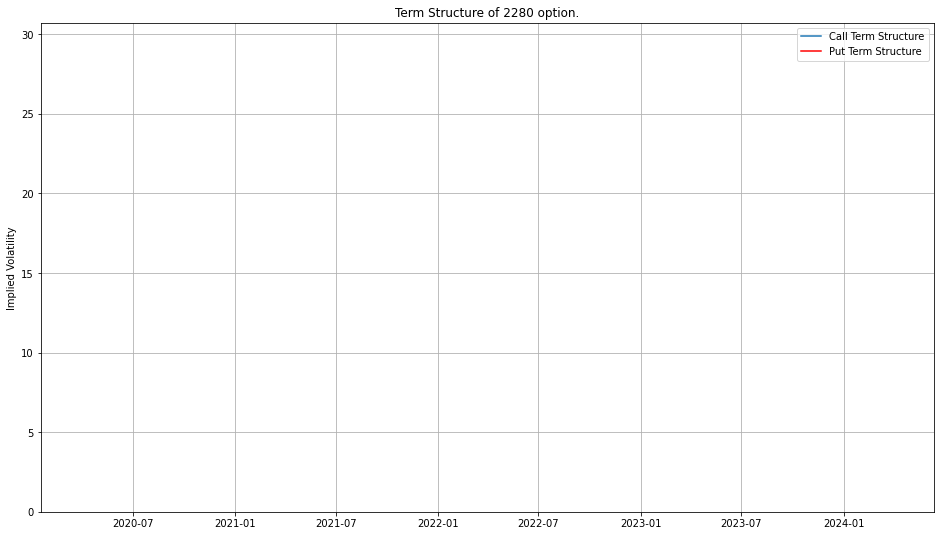

In [27]:
plot_graph_strike(strike_df, ATM)

In [28]:
def call_price(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r*t)*norm.cdf(d2)

In [29]:
def put_price(S, K, r, vol, t):
    return call_price(S, K, r, vol, t) - S + np.exp(-r*(t))*K

In [30]:
def delta(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    delta_call = np.exp(-(t))*norm.cdf(d1)
    delta_put = -np.exp(-(t))*norm.cdf(-d1)
    return delta_call, delta_put

In [31]:
def gamma(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    gamma = (norm.pdf(d1)) / (S * vol * np.sqrt(t)) 
    return gamma

In [32]:
def vega(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    return S * norm.pdf(d1) * np.sqrt(t)

In [33]:
def rho(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    rho_call = K*(t)*np.exp(-r*(t))*norm.cdf(d2)
    rho_put = -K*(t)*np.exp(-r*(t))*norm.cdf(-d2) 
    return rho_call, rho_put

In [34]:
def theta(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    theta_call = -(S*norm.pdf(d1)*vol / (2*np.sqrt(t))) - r*K*np.exp(-r*(t))*norm.cdf(d2) 
    theta_put = -(S*norm.pdf(d1)*vol / (2*np.sqrt(t))) + r*K*np.exp(-r*(t))*norm.cdf(-d2)
    return theta_call, theta_put

In [35]:
def charm(S, K, r, vol, t):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2)*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    charm = -norm.pdf(d1)*(2*r*(t) - d2*vol*np.sqrt(t))/(2*(t)*vol*np.sqrt(t))
    return charm

In [36]:
def greeks(data,expiry=0, rate=0.06, volatility=0.2, days_to_exp=1):
    # we need Stock Price, Strike Price, rate of interest, volatility, and time to expiry
    df = pd.DataFrame(columns = ["Call Charm","Call Rho","Call Theta","Call Gamma","Call Vega","Call IV","Call Delta","Strike","Put Delta","Put IV","Put Vega","Put Gamma","Put Theta","Put Rho","Put Charm"], index = data[expiry].index)
    S = underlying_ltp
    r = rate # CPI, FD rate or repo rate, you can choose according to your convenienece
    vol = volatility # You can use VIX value or derive your own
    t = days_to_exp/252
    df["Strike"] = data[expiry]["Strike"]
    df["Call IV"] = data[expiry]["Call IV"]
    df["Put IV"] = data[expiry]["Put IV"]
    for i in range(len(df["Strike"])):
        K = df.iloc[i,7]
        df.iloc[i,0] = df.iloc[i,-1] = charm(S,K,r,vol,t)
        df.iloc[i,3] = df.iloc[i,-4] = gamma(S,K,r,vol,t)
        df.iloc[i,4] = df.iloc[i,-5] = vega(S,K,r,vol,t)
        df.iloc[i,1], df.iloc[i,-2] = rho(S,K,r,vol,t)
        df.iloc[i,2], df.iloc[i,-3] = theta(S,K,r,vol,t)
        df.iloc[i,6], df.iloc[i,-7] = delta(S,K,r,vol,t)
        df.iloc[i,6] = df.iloc[i,6]*100 
        df.iloc[i,-7] = df.iloc[i,-7]*100
        df = np.round(df,4)
    return df

In [37]:
option_greeks = greeks(expiry_df,expiry=0, days_to_exp=5)

In [38]:
option_greeks

,Call Charm,Call Rho,Call Theta,Call Gamma,Call Vega,Call IV,Call Delta,Strike,Put Delta,Put IV,Put Vega,Put Gamma,Put Theta,Put Rho,Put Charm
0,0.303946,41.559799,-132.395747,0.000064,1.333118,26.54,97.912412,2100,-0.123015,34.22,1.333118,0.000064,-6.545658,-0.057294,0.303946
1,4.942756,39.688807,-372.681505,0.002424,50.131459,24.62,89.682279,2200,-8.353149,31.46,50.131459,0.002424,-240.838555,-3.910052,4.942756
2,2.794658,29.149836,-681.204188,0.005689,117.669659,24.62,64.821913,2260,-33.213514,30.82,117.669659,0.005689,-545.76552,-15.638083,2.794658
3,-0.096686,23.940063,-715.566099,0.00617,127.613363,24.95,53.039713,2280,-44.995714,30.45,127.613363,0.00617,-578.928859,-21.244209,-0.096686
4,-3.145766,18.553102,-688.992865,0.006071,125.573072,24.08,40.979442,2300,-57.055985,30.27,125.573072,0.006071,-551.157053,-27.027524,-3.145766
5,-5.522624,13.505164,-607.325166,0.005434,112.397926,24.19,29.754905,2320,-68.280522,30.39,112.397926,0.005434,-468.290781,-32.471815,-5.522624
6,-6.697751,9.202521,-490.177946,0.004435,91.736016,24.35,20.233301,2340,-77.802126,30.26,91.736016,0.004435,-349.944989,-37.170811,-6.697751
7,-6.616427,5.856408,-362.612944,0.003309,68.433168,24.32,12.854268,2360,-85.181159,29.57,68.433168,0.003309,-221.181415,-40.913277,-6.616427
8,-5.619339,3.475713,-246.212303,0.002261,46.76622,24.35,7.617989,2380,-90.417439,30.71,46.76622,0.002261,-103.582202,-43.690326,-5.619339
9,-4.208775,1.922259,-153.700057,0.001419,29.342688,24.44,4.208125,2400,-93.827302,31.47,29.342688,0.001419,-9.871384,-45.640133,-4.208775


In [39]:
def plot_vega(df):
    plt.figure(figsize=(16,9))
    plt.plot(df["Strike"],df["Call Vega"], color='r')
    plt.plot(df["Strike"],df["Put Vega"], color='b')
    plt.grid('True')
    plt.title("Call/Put Vegas of option.")
    plt.legend(["Call Vega","Put Vega"])
    plt.ylabel("Option Vega")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [40]:
def plot_delta(df):
    plt.figure(figsize=(16,9))
    plt.plot(df["Strike"],df["Call Delta"])
    plt.plot(df["Strike"],df["Put Delta"])
    plt.grid('True')
    plt.title("Call/Put deltas of option.")
    plt.legend(["Call Delta","Put Delta"])
    plt.ylabel("Option Delta")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [41]:
# plot_delta(option_greeks)

In [42]:
# plot_vega(option_greeks)

In [43]:
def implied_vol(data,expiry=0, rate=0.06, volatility=0.2, days_to_exp=1, tol = 1e-5):
    # we need Stock Price, Strike Price, rate of interest, volatility, and time to expiry
    df = pd.DataFrame(columns = ["BSM Call IV","Call IV","Call LTP","Strike","Put LTP","Put IV","BSM Put IV"], index = data[expiry].index)
    S = underlying_ltp
    r = rate # CPI, FD rate or repo rate, you can choose according to your convenienece
    t = days_to_exp/252
    df["Strike"] = data[expiry]["Strike"]
    df["Call IV"] = data[expiry]["Call IV"]
    df["Put IV"] = data[expiry]["Put IV"]
    df["Call LTP"] = data[expiry]["Call LTP"]
    df["Put LTP"] = data[expiry]["Put LTP"]
    max_iter = 200
    # Make sure you start with a high value or the code will throw an error
    vol_old_call = 0.5
    vol_old_put = 0.5
    
    for i in range(len(data[expiry]["Strike"])):
        for j in range(max_iter):
            BSM_call_price  = call_price(underlying_ltp, df.iloc[i,3],r,vol_old_call,t)  
            BSM_put_price = put_price(underlying_ltp, df.iloc[i,3],r,vol_old_put,t)
            cprime = vega(underlying_ltp, df.iloc[i,3],r, vol_old_call, t)
            C = BSM_call_price - df.iloc[i,2]
            P = BSM_put_price - df.iloc[i,-3]
            
            vol_new_call = vol_old_call - C/cprime
            vol_new_put = vol_old_put - P/cprime
            
            new_BSM_call_price = call_price(underlying_ltp, df.iloc[i,3],r,vol_new_call,t)
            new_BSM_put_price = put_price(underlying_ltp, df.iloc[i,3],r,vol_new_call,t)
            if (abs(vol_new_call/vol_old_call)-1 < tol ): #and abs(vol_new_put/vol_old_put)-1 < tol
                break
            
            vol_old_call = vol_new_call
            vol_old_put = vol_new_put
             
        df.iloc[i,0] = vol_new_call*100
        df.iloc[i,-1] = vol_new_put*100
    return df

In [44]:
iv = implied_vol(expiry_df, expiry=0,days_to_exp=5)

In [45]:
iv

,BSM Call IV,Call IV,Call LTP,Strike,Put LTP,Put IV,BSM Put IV
0,75.560238,26.54,213.50,2100,23.30,34.22,70.350882
1,64.637753,24.62,130.90,2200,43.50,31.46,63.096851
2,61.570359,24.62,92.00,2260,64.65,30.82,60.257117
3,61.520168,24.95,81.70,2280,72.65,30.45,58.911586
4,59.051329,24.08,69.05,2300,81.90,30.27,57.949551
5,58.803158,24.19,60.00,2320,92.70,30.39,57.594463
6,58.792635,24.35,52.00,2340,103.55,30.26,56.67737
7,58.484474,24.32,44.35,2360,113.60,29.57,54.510469
8,58.412205,24.35,37.70,2380,129.30,30.71,56.275828
9,58.572366,24.44,32.00,2400,144.50,31.47,57.132437


In [46]:
def plot_IV(df, o_type="Call"):
    plt.figure(figsize=(16,9))
    if o_type.lower() == "call":
        plt.plot(df["Strike"],df["Call IV"], color='r')
        plt.plot(df["Strike"],df["BSM Call IV"], color='b')
        plt.title("Market IV vs BSM Vol for Call options.")
    elif o_type.lower() == "put":
        plt.plot(df["Strike"],df["Put IV"], color='r')
        plt.plot(df["Strike"],df["BSM Put IV"], color='b')
        plt.title("Market IV vs BSM Vol for Put options.")
    plt.grid('True')
    plt.legend(["Mkt IV","BSM Vol"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

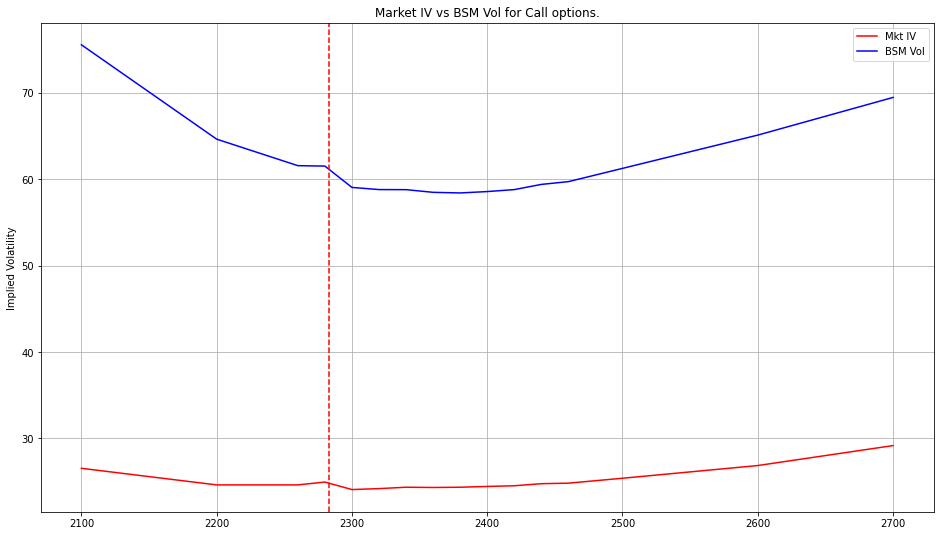

In [47]:
plot_IV(iv)

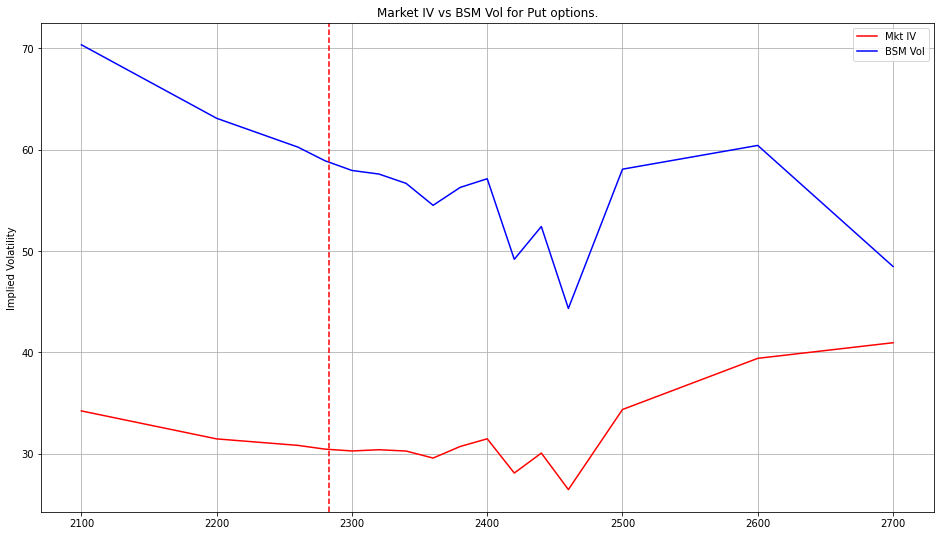

In [48]:
plot_IV(iv, o_type="PUT")